In [64]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TiDEModel
from darts.models import LinearRegressionModel
from darts.models import ARIMA
from darts.models import TransformerModel



CREATE THE GRAPH OF THE CUMULATIVE POINTS OF ALL THE TEAMS

Index(['squadra', 'avversario', 'home/away', 'punti', 'numero della giornata',
       'punti cumulativi', 'punti avversario', 'punti cumulativi before match',
       'punti avversario before match', 'differenza punti before match'],
      dtype='object')


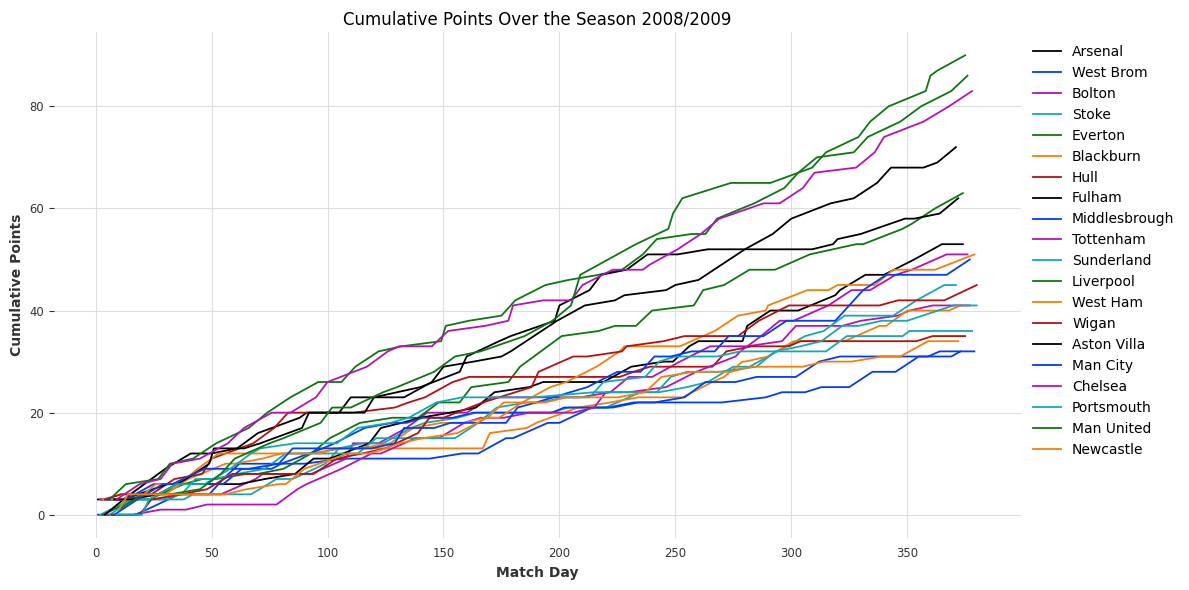

In [65]:
file_path = 'Data/2008_2009_transformed_new_4.csv'
data = pd.read_csv(file_path)

print(data.columns)
# Plot cumulative points for each team
teams = data['squadra'].unique()

plt.figure(figsize=(12, 6))

for team in teams:
    team_data = data[data['squadra'] == team]
    plt.plot(team_data['numero della giornata'], team_data['punti cumulativi'], label=team)

plt.xlabel('Match Day')
plt.ylabel('Cumulative Points')
plt.title('Cumulative Points Over the Season 2008/2009')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

CREATE A DICT IN ORDER TO CREATE THE PLOT ABOUT THE COMPARISON BETWEEN THE TRUE RANK AND THE PREDICTED RANK

In [66]:
final_points = {}
for team in data['squadra'].unique():
    team_data = data[data['squadra'] == team]
    last_cumulative_points = team_data['punti cumulativi'].iloc[-1]
    final_points[team] = last_cumulative_points

SUBSTITUTE THE TEAM AND AWAY/HOME WITH A NUMBER ID

In [67]:
id_avversario = {}
i = 0
for avversario in data['avversario'].unique():
    if avversario not in id_avversario:
        id_avversario[avversario] = i
        i += 1

print(id_avversario)

home_away = {}
home_away['home'] = 0
home_away['away'] = 1
print(home_away)
    

{'West Brom': 0, 'Arsenal': 1, 'Stoke': 2, 'Bolton': 3, 'Blackburn': 4, 'Everton': 5, 'Fulham': 6, 'Hull': 7, 'Tottenham': 8, 'Middlesbrough': 9, 'Liverpool': 10, 'Sunderland': 11, 'Wigan': 12, 'West Ham': 13, 'Man City': 14, 'Aston Villa': 15, 'Portsmouth': 16, 'Chelsea': 17, 'Newcastle': 18, 'Man United': 19}
{'home': 0, 'away': 1}


CONVERT THE DATASET INTO TIME-SERIES WITH TARGET VALUES AND COVARIATES

In [5]:
series_team = {}
data['avversario'] = data['avversario'].map(id_avversario)
data['home/away'] = data['home/away'].map(home_away)

for team in data['squadra'].unique():
    # Filtra i dati per la squadra corrente
    team_data = data[data['squadra'] == team].drop(columns=['squadra'])
    
    # Creazione di un indice temporale basato sul numero di righe per la squadra
    date_range = pd.date_range(start='2008-08-16', periods=len(team_data), freq='W')  # Usa 'W' per settimanale
    
    # Imposta l'indice del DataFrame
    team_data.index = date_range
 
    target = TimeSeries.from_dataframe(team_data, value_cols=['punti', 'punti cumulativi'])

    covariates = TimeSeries.from_dataframe(team_data, value_cols=['avversario' , 'home/away'])
    series_team[team] = (target, covariates)

    

0       0
1       1
2       2
3       3
4       4
       ..
755    11
756     9
757    13
758    16
759    12
Name: avversario, Length: 760, dtype: int64


CONVERT THE DATASET INTO TIME-SERIES FOR UNIVARIATE FORECASTING

In [32]:
series_team_singlemode = {}


data['avversario'] = data['avversario'].map(id_avversario)
data['home/away'] = data['home/away'].map(home_away)



for team in data['squadra'].unique():
    # Filtra i dati per la squadra corrente
    team_data = data[data['squadra'] == team].drop(columns=['squadra'])
    
    # Creazione di un indice temporale basato sul numero di righe per la squadra
    date_range = pd.date_range(start='2008-08-16', periods=len(team_data), freq='W')  # Usa 'W' per settimanale
    
    # Imposta l'indice del DataFrame
    team_data.index = date_range
 
    target_arima = TimeSeries.from_dataframe(team_data, value_cols=['punti cumulativi'])
    
    series_team_singlemode[team] = target_arima


    

COMPUTE THE ABSOLUTE ERROR

In [6]:
def mean_absolute_error(predictions, series_team = series_team, valori_predetti = 8):
    total_absolute_errors = []
    errore_squadra = []
    
    for team in data['squadra'].unique():
        
        absolute_errors = [abs(p - t) for p, t in zip(predictions[team].pd_dataframe()['punti cumulativi'], series_team[team][0][-valori_predetti:].pd_dataframe()['punti cumulativi'])]
        
        total_absolute_errors.extend(absolute_errors)
    
    mae = sum(total_absolute_errors) / len(total_absolute_errors)
    

        
    return mae
    

CHECK THE POINT PREDICTION FOR SINGLE MATCH

In [7]:
def noramlized_points (predictions , singlemode):
    predictions_changed = {}
    
    for team in data['squadra'].unique():
        
        if singlemode == False:
            min_val = predictions[team].pd_dataframe()['punti'].min()
            max_val = predictions[team].pd_dataframe()['punti'].max()
            predictions_normalized = (predictions[team].pd_dataframe()['punti'] - min_val) / (max_val - min_val)

        else:
            
            return predictions

    # Passaggio 2: Mappatura al range [0, 3]
        predictions_mapped = predictions_normalized * 3
        
        
        list_team = []
        for index, value in enumerate(predictions_mapped):
            if value <= 0.5:

                list_team.append(0)

            elif value <= 2.0:
                
                list_team.append(1)


            elif value <= 3.0:
                list_team.append(3)
        
        predictions_changed[team] = list_team
    

    
    return predictions_changed


            

COMPUTE THE PERCENTAGE OF CORRECT PREDICTIONS OF SINGLE MATCHES

In [8]:
def percentuale_punti_corretti(predictions, series_team = series_team, valori_predetti = 8):
    normalized_prediction = noramlized_points(predictions,singlemode=False)
    corrette = 0
    tot_pred = len(predictions) * valori_predetti
    for team in predictions:
        for reale, previsione in zip(series_team[team][0][-valori_predetti:].pd_dataframe()['punti'],normalized_prediction[team]):
            if reale == previsione:
                corrette += 1
                
    return (corrette / tot_pred) * 100
    

COMPARE THE TRUE RANK WITH THE PREDICTED ONE

In [40]:
def compare_positions(predictions, final_points = final_points, single_mode = False):    
    sorted_teams_actual = sorted(final_points.items(), key=lambda item: item[1], reverse=True)

    # Creare un dizionario per i punti cumulativi finali predetti
    if single_mode == False:
        predicted_points_final = {}
        for team in predictions.keys():
            predicted_points_final[team] = predictions[team].values()[-1][1]  # Assicurati che sia un valore scalare
        sorted_teams_predicted = sorted(predicted_points_final.items(), key=lambda item: item[1], reverse=True)
    else:
        predicted_points_final = {}
        for team in predictions.keys():
            predicted_points_final[team] = predictions[team].values()[-1][0]  # Assicurati che sia un valore scalare
        sorted_teams_predicted = sorted(predicted_points_final.items(), key=lambda item: item[1], reverse=True)

    print(sorted_teams_predicted)
    # Preparazione dei dati per il grafico combinato
    teams_actual = [team for team, _ in sorted_teams_actual]
    points_actual = [final_points.get(team, 0) for team in teams_actual]
    teams_predicted = [team for team, points in sorted_teams_predicted]
    points_predicted = [predicted_points_final.get(team, 0) for team in teams_predicted]

    # Calcoliamo l'indice per posizionare le barre in modo affiancato
    bar_width = 0.4  # Larghezza delle barre

    # Posizioni delle barre
    index = np.arange(len(teams_actual))

    # Creazione del grafico combinato
    plt.figure(figsize=(16, 10))

    # Grafico per i punti cumulativi finali effettivi (in blu)
    bars_actual = plt.barh(index - bar_width/2, points_actual, height=bar_width, color='blue', alpha=0.7, label='Effettivo')

    # Grafico per i punti cumulativi finali predetti (in giallo)
    bars_predicted = plt.barh(index + bar_width/2, points_predicted, height=bar_width, color='yellow', alpha=0.7, label='Predetto')

    # Etichette sugli assi (nomi delle squadre a sinistra)
    plt.yticks(index, [])  # Rimuovo le etichette sull'asse y

    # Aggiungi etichette alle barre (solo sulla sinistra)
    for i, team in enumerate(teams_actual):
        plt.text(0, i - bar_width/2, team, ha='right', va='center', color='black')

    for i, team in enumerate(teams_predicted):
        plt.text(0, i + bar_width/2, team, ha='right', va='center', color='black')

    plt.xlabel('Punti Cumulativi Finali')
    plt.title('Confronto Classifica Effettiva vs Predetta')
    plt.gca().invert_yaxis()
    plt.legend(loc='lower right')  # Aggiungi la legenda in basso a destra

    plt.show()

In [10]:
giornata =  []
for i in range(38):
    giornata.append(i+1)
    

PLOT THE TRUE CUMULATIVE POINT AND SINGLE MATCH POINTS WITH PREDICTED CUMULATIVE POINT AND SINGLE MATCH POINT

In [38]:
def plot_prediction(predictions, series_team = series_team, giornata= giornata, singlemode = False, giorni_predetti = 8): 
    
    print('MEAN ABSOLUTE ERROR:')
    print(mean_absolute_error(predictions))   
    selected_teams = ['Liverpool', 'Arsenal']

    # Creazione dei grafici
    plt.figure(figsize=(14, 7))

    for i, team in enumerate(selected_teams, start=1):
        plt.subplot(1, len(selected_teams), i)
        
        # Ottieni i dati effettivi per la squadra
        series = series_team.get(team)
        if series is None:
            continue
        
     
        
        if singlemode == False:
            plt.plot(giornata , series[0].values(), label='Punti', color='green', linestyle='--', marker='o')
            plt.plot(giornata, series[0].values(), label='Punti Cumulativi', color='blue', linestyle='-')
        else:
            plt.plot(giornata, series.values(), label='Punti Cumulativi', color='blue', linestyle='-')
        

        predictions_graph = noramlized_points(predictions, singlemode)
        pred = predictions_graph[team]
        
        if singlemode == False:
            #plt.plot(pred.time_index, pred['punti'].values(), label='Previsione Punti', color='lightgreen', linestyle='--', marker='o')
            plt.plot(giornata[-giorni_predetti:], pred, label='Previsione Punti', color='lightgreen', linestyle='--', marker='o')
        plt.plot(giornata[-giorni_predetti:], predictions[team]['punti cumulativi'].values(), label='Previsione Punti Cumulativi', color='lightblue', linestyle='-')
        
  

        plt.title(f"Confronto per {team}")
        plt.xlabel('Data')
        plt.ylabel('Valori')
        plt.legend()

    plt.tight_layout()
    plt.show()


CREATE TRAIN AND TESTING SET

In [58]:
train_team = {}
val_team = {}
for team, (target, covariates) in series_team.items():
    train_team[team] = (target[:-8], covariates[:-8])
    val_team[team] = (target[-8:], covariates[-8:])

CREATE TIDE MODEL

In [41]:
model_tide_covariates = TiDEModel(
    input_chunk_length=16,
    # num_encoder_layers = 15,
    # num_decoder_layers=15,
    output_chunk_length=8,
    # hidden_size = 64,
    # use_layer_norm=True,
    # batch_size = 1,
    n_epochs=200,

)

TRAIN TIDE MODEL WITH COVARIATES

In [ ]:
predictions = {}

for team in train_team:
    
    
    target_train, covariates_train = train_team[team]
    target_val, covariates_val = val_team[team]
    #addestro il modello 
    model_tide_covariates.fit(target_train, past_covariates=covariates_train)
    
    # Previsione
    
    pred = model_tide_covariates.predict(n=8, past_covariates= series_team[team][1])
    
    # Salva le previsioni
    predictions[team] = pred

PRINT THE ACCURACY AND THE PLOTS OF THE PREDICTIONS

In [45]:
print(percentuale_punti_corretti(predictions))

31.25


MEAN ABSOLUTE ERROR:
4.432634303239871


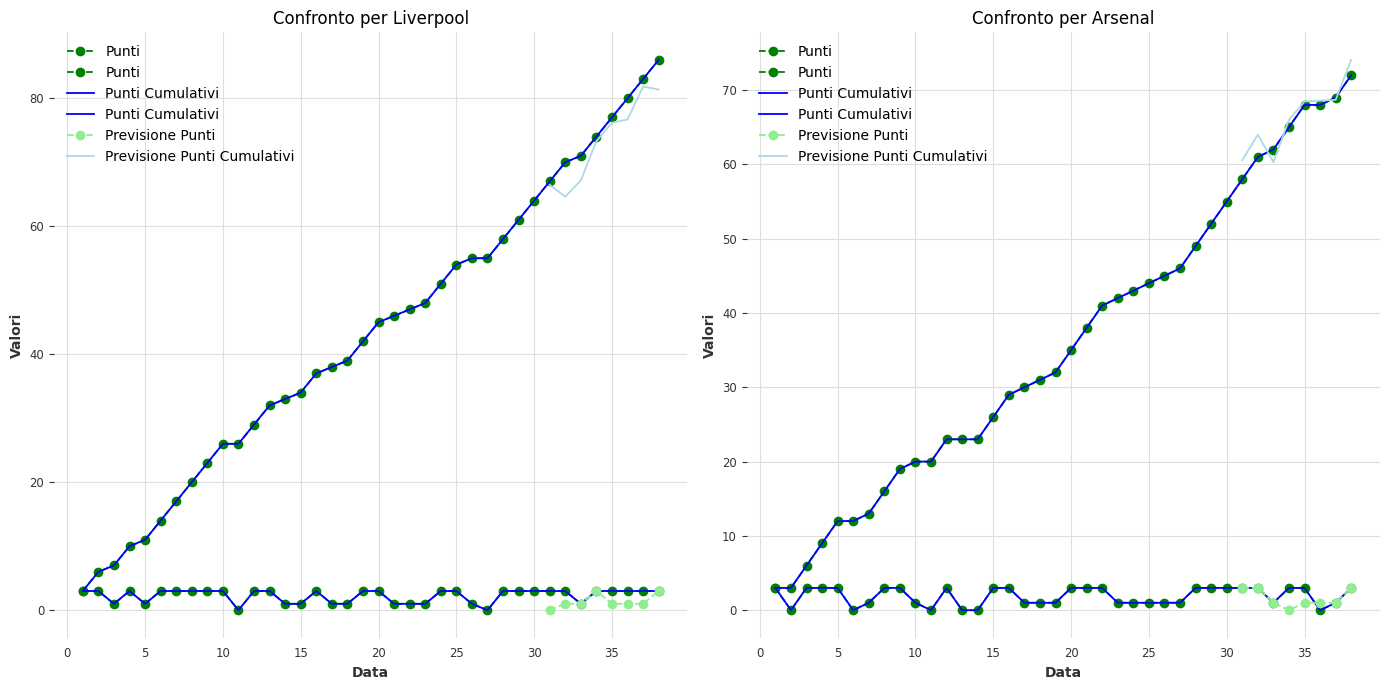

In [46]:
plot_prediction(predictions)

[('Man United', 96.62101233925344), ('Chelsea', 82.6543878638413), ('Liverpool', 81.36312631770488), ('Arsenal', 74.06840018346426), ('Everton', 63.77701038312385), ('Aston Villa', 63.624194585253505), ('West Ham', 59.78040921472724), ('Tottenham', 58.287335728875874), ('Wigan', 54.79182743547601), ('Man City', 54.606582189875965), ('Fulham', 50.25671858489947), ('Sunderland', 45.61332902093575), ('Bolton', 44.184813924298005), ('Blackburn', 41.304883585795245), ('Portsmouth', 40.95260850516772), ('Hull', 40.43861712822726), ('Stoke', 36.468672961204526), ('Middlesbrough', 32.70014598573588), ('West Brom', 31.094905928990592), ('Newcastle', 29.00737268661402)]


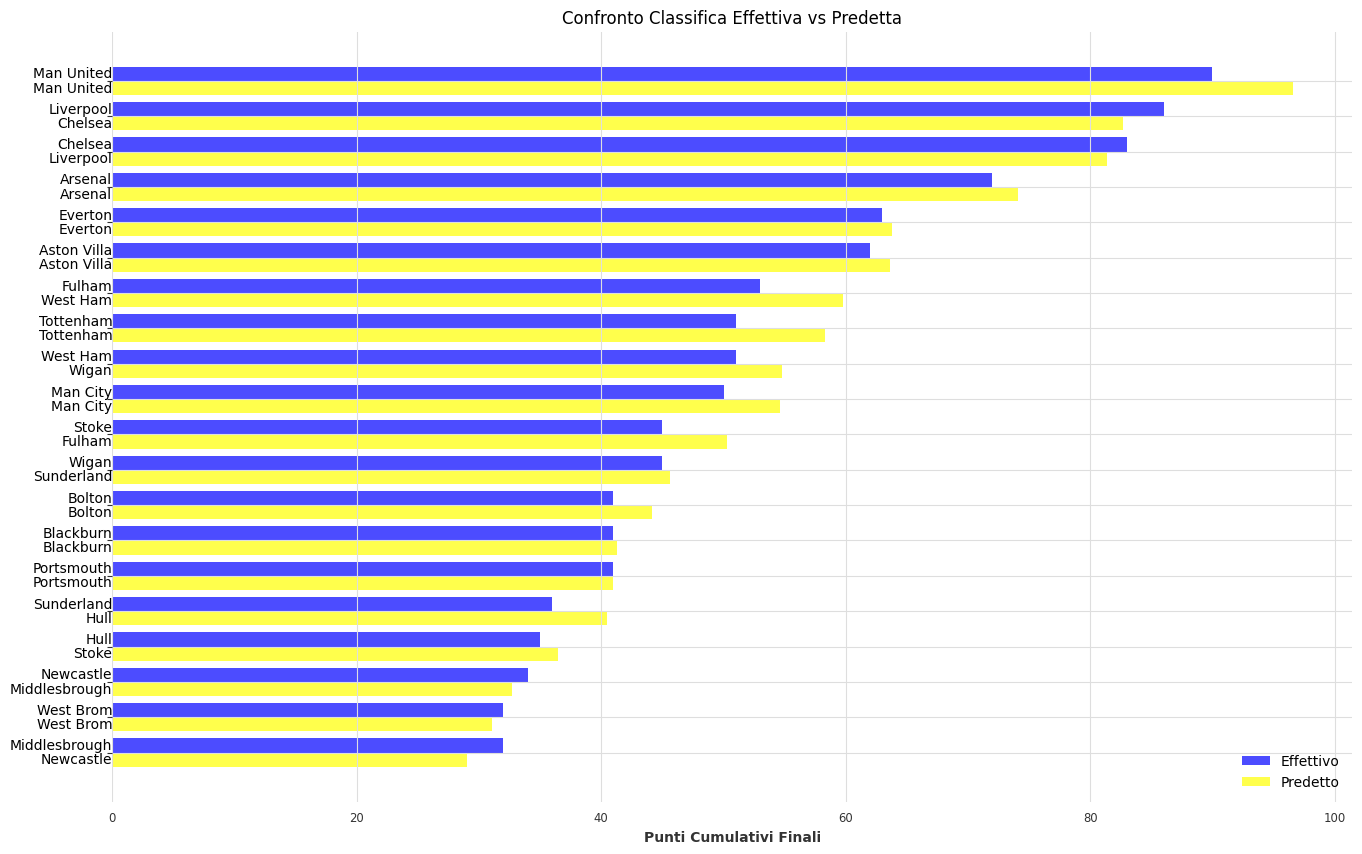

In [47]:
compare_positions(predictions)

TRAIN LINEAR REGRESSION MODEL

In [48]:
model_LR = LinearRegressionModel(lags=8, output_chunk_length=3)


# Dizionario per le previsioni
predictions = {}

# Addestramento e previsione per ogni squadra
for team in train_team:
    
    
    target_train, covariates_train = train_team[team]
   
    model_LR.fit(target_train)
    
    target_val, covariates_val = val_team[team]
    # Previsione
    #pred = model_LR.predict(n=len(target_val),past_covariates=series_team[team][1])  # Previsione per i prossimi 10 punti temporali
    pred = model_LR.predict(n=len(target_val))
    
    # Salva le previsioni
    predictions[team] = pred

PRINT ACCURACY AND PLOT THE PREDICTIONS OF THE MODEL

MEAN ABSOLUTE ERROR:
4.436868300875781


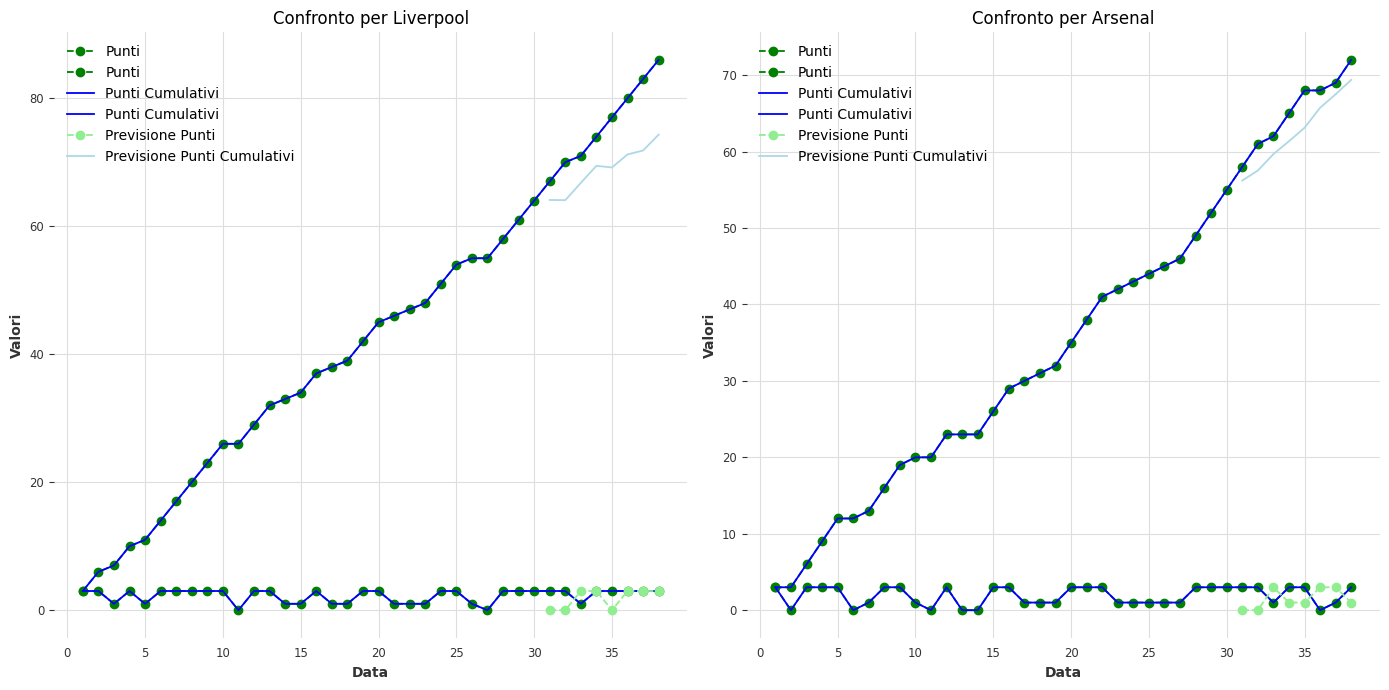

In [49]:
plot_prediction(predictions)

In [50]:
print(percentuale_punti_corretti(predictions))

38.75


[('Man United', 93.20041421136025), ('Liverpool', 74.30740909062727), ('Chelsea', 72.65366050279606), ('Aston Villa', 70.53942883219563), ('Arsenal', 69.38068328635049), ('West Ham', 62.837661779643994), ('Everton', 59.76109144525611), ('Man City', 54.624355405470624), ('Blackburn', 54.52021615190164), ('Wigan', 52.05860386057337), ('Sunderland', 45.34063111469075), ('Fulham', 45.16831038022593), ('Tottenham', 43.73426466424283), ('Bolton', 41.49743976963519), ('Portsmouth', 33.44827619184507), ('Hull', 33.24435773146914), ('West Brom', 32.61860559395572), ('Newcastle', 31.865106268061513), ('Stoke', 31.32393193334198), ('Middlesbrough', 26.829350059376857)]


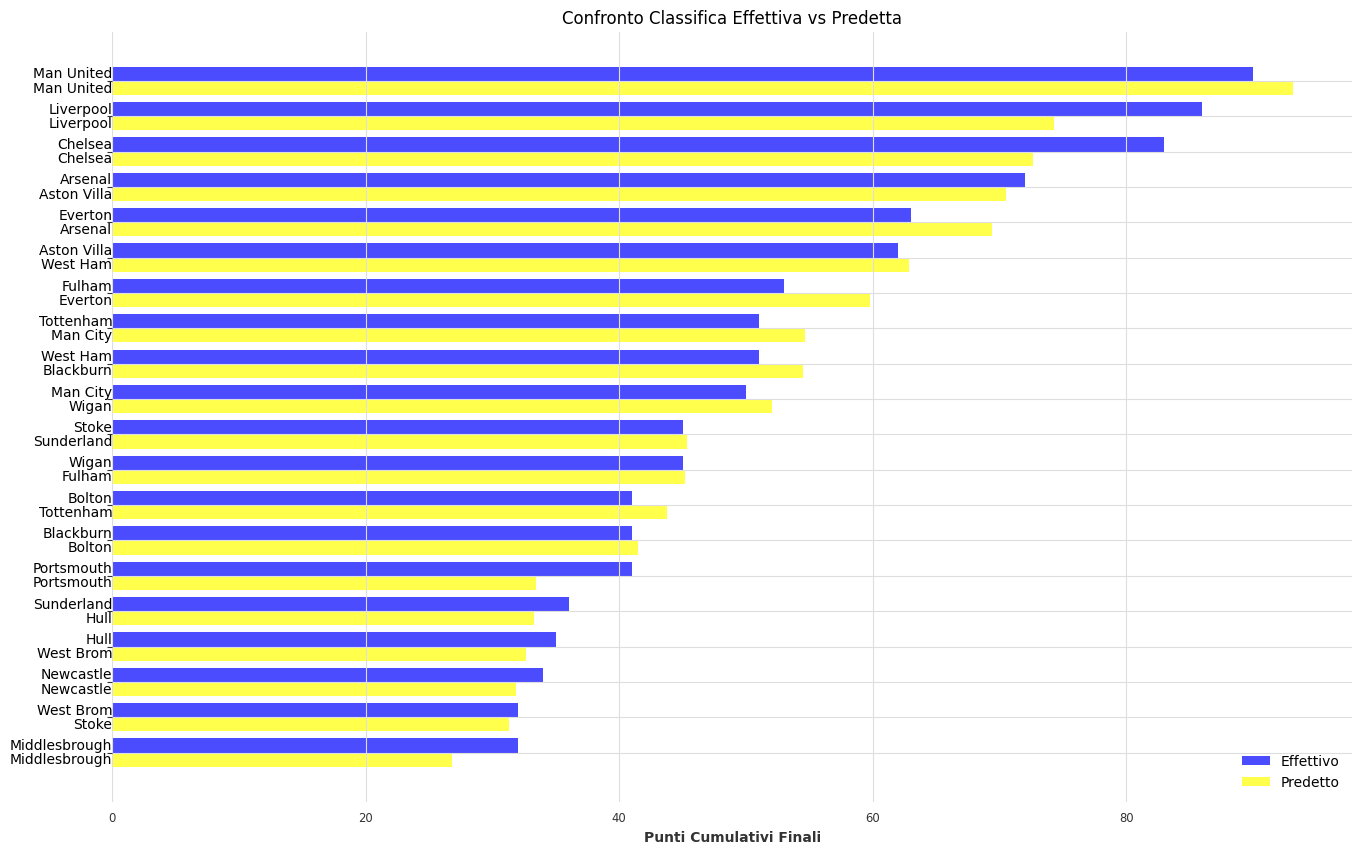

In [51]:
compare_positions(predictions)

In [52]:
train_team = {}
val_team = {}
for team, series in series_team_singlemode.items():
    train_team[team] = series[:-6]

CREATE AND TRAIN ARIMA MODEL

In [53]:
model_A = ARIMA(p=15, d=1, q=2)
predictions = {}

# Addestramento e previsione per ogni squadra
for team in train_team:
    # Supponiamo di avere future_covariates disponibili
    
    target_train = train_team[team]
    
    # Addestra il modello
    model_A.fit(target_train)
    
    # Previsione
    pred = model_A.predict(6)  # Previsione per i prossimi 10 punti temporali
    
    # Salva le previsioni
    predictions[team] = pred

c:\Users\Tommaso\miniconda3\envs\deeplearningproject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Tommaso\miniconda3\envs\deeplearningproject\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Tommaso\miniconda3\envs\deeplearningproject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


PRINT AND PLOT THE PREDICTIONS OF THE MODEL

MEAN ABSOLUTE ERROR:
3.2853123900513386


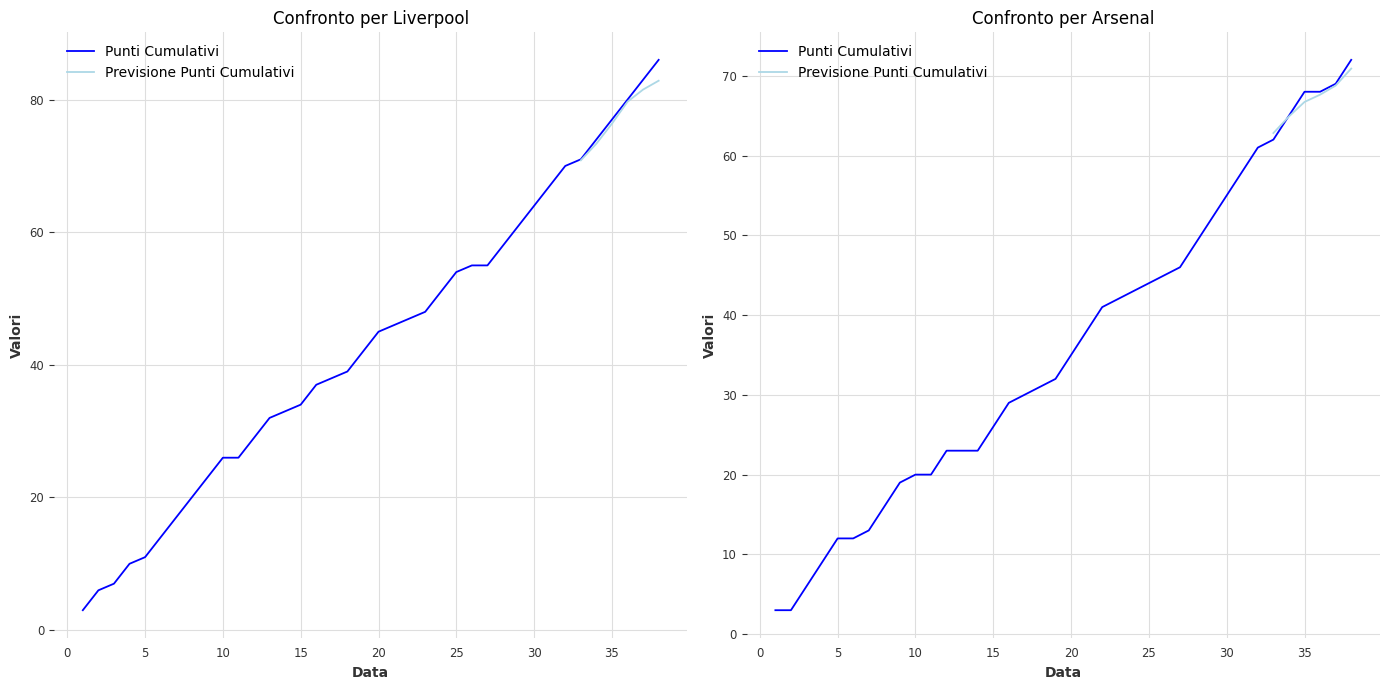

In [54]:
plot_prediction(predictions,series_team=series_team_singlemode, singlemode = True, giorni_predetti=6)

[('Liverpool', 82.85279181634556), ('Man United', 82.51561296978883), ('Chelsea', 79.29432018248997), ('Arsenal', 70.90631755756391), ('Everton', 61.776381794648984), ('Aston Villa', 60.42920934117195), ('Wigan', 55.615449475107575), ('West Ham', 52.546665759335774), ('Fulham', 49.40222100520845), ('Portsmouth', 49.02116166661842), ('Stoke', 45.5162944865445), ('Tottenham', 45.502353134781075), ('Man City', 45.19077217295727), ('Bolton', 44.02925860654195), ('Blackburn', 42.50803523587956), ('Sunderland', 41.485751961006564), ('Hull', 38.630966697545006), ('Newcastle', 34.86945268643208), ('Middlesbrough', 33.36044709058374), ('West Brom', 30.992955559939997)]


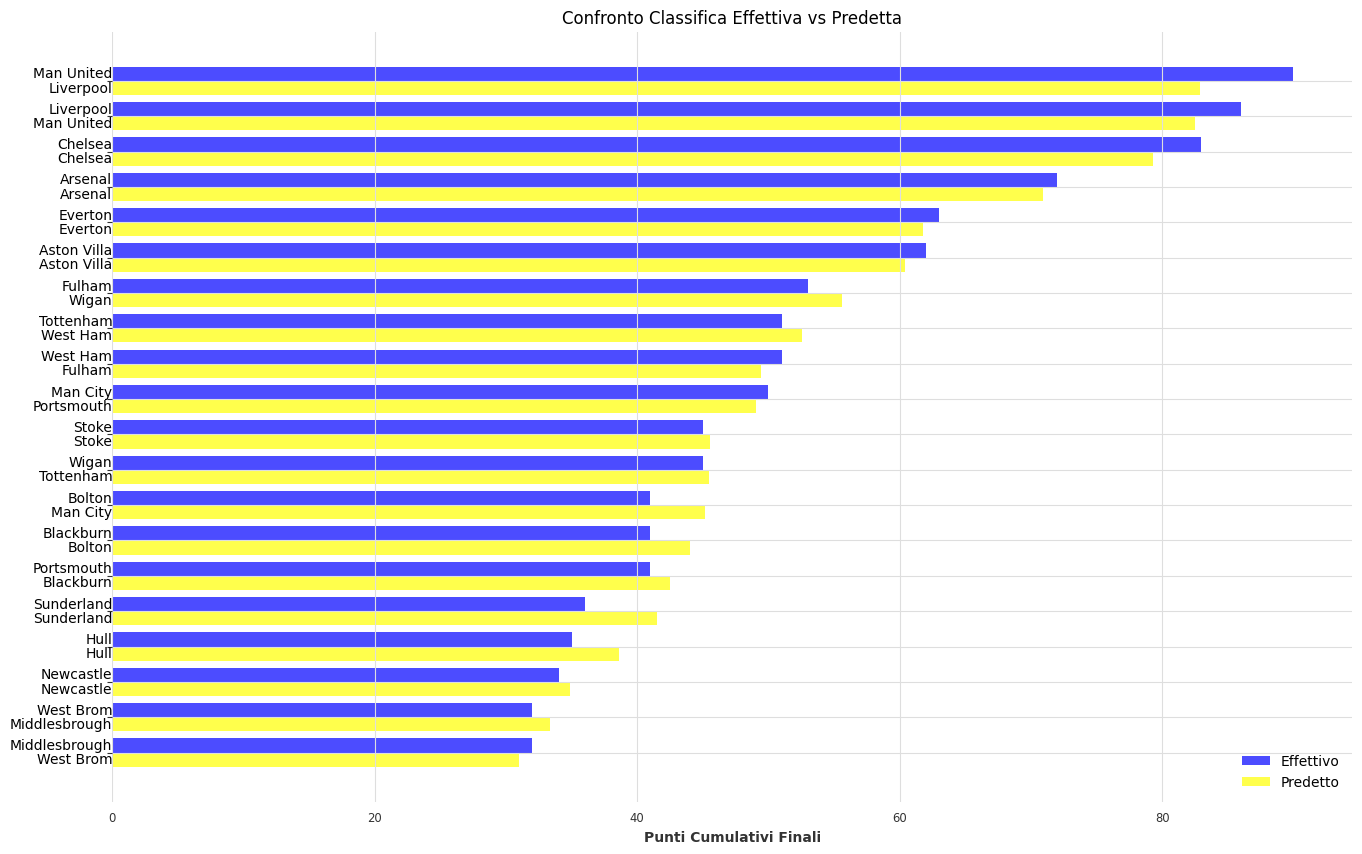

In [55]:
compare_positions(predictions, single_mode=True)

CREATE AND TRAIN TRANSFORMER MODEL

In [59]:
model_T = TransformerModel(
    input_chunk_length= 22,
    output_chunk_length= 8,
    n_epochs=250
)

In [ ]:
predictions = {}
for team in train_team:
    # Supponiamo di avere future_covariates disponibili
    
    target_train, covariates_train = train_team[team]
   
    model_T.fit(target_train, past_covariates=covariates_train)
    
    target_val, covariates_val = val_team[team]
    # Previsione
    pred = model_T.predict(n=len(target_val), past_covariates=series_team[team][1]) 
    
    # Salva le previsioni
    predictions[team] = pred

PRINT THE ACCURACY AND PLOT THE PREDICTIONS OF THE MODEL

MEAN ABSOLUTE ERROR:
11.69617900271316


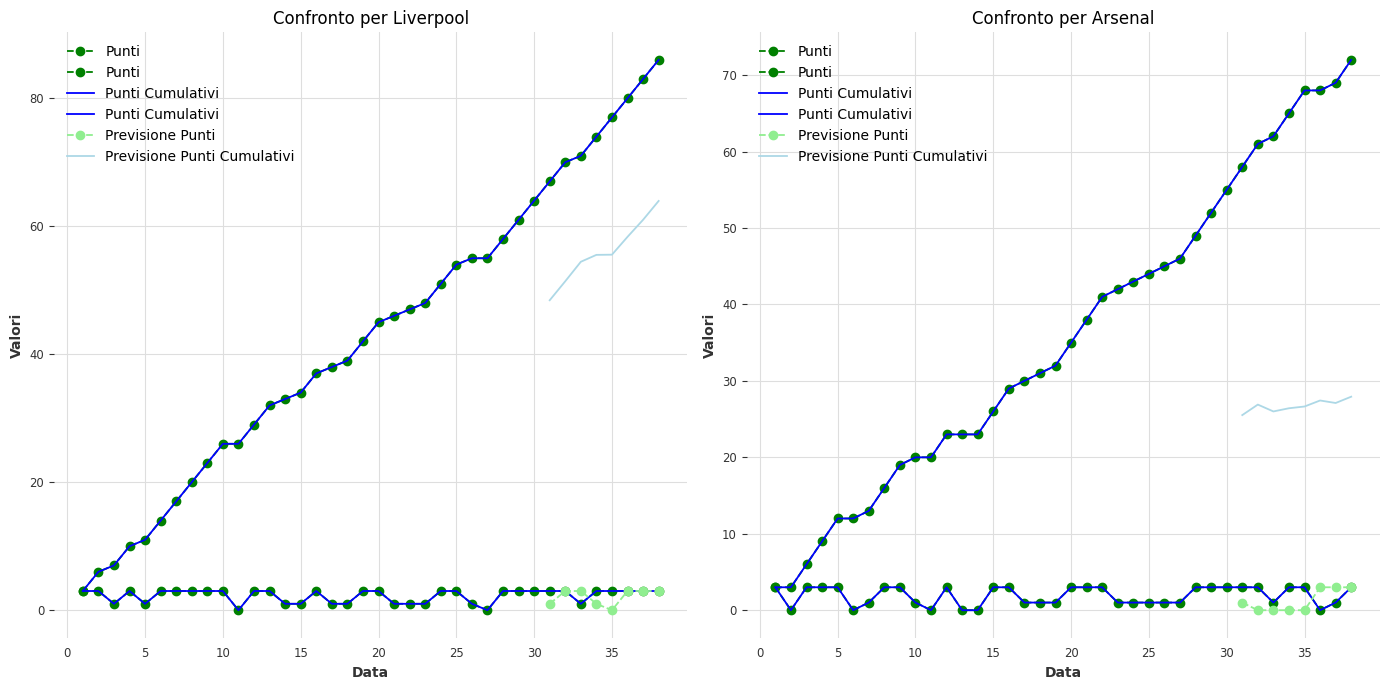

In [61]:
plot_prediction(predictions)

In [62]:
print(percentuale_punti_corretti(predictions))

42.5


[('Man United', 69.55225128456436), ('Liverpool', 63.95201485137849), ('Chelsea', 61.671226387218404), ('Aston Villa', 52.37427404320011), ('Everton', 48.42049257252471), ('Wigan', 41.76149492893026), ('West Ham', 41.71711161162332), ('Fulham', 40.343909987518835), ('Man City', 39.077197009601115), ('Tottenham', 38.453058953616946), ('Bolton', 34.36238785628441), ('Hull', 33.43005133249297), ('Stoke', 32.58128244877529), ('Sunderland', 32.41142425044332), ('Portsmouth', 32.40713222117847), ('Blackburn', 31.491353753946143), ('Newcastle', 28.274581250311776), ('Arsenal', 27.932426006447002), ('Middlesbrough', 27.517790223240468), ('West Brom', 24.562627754403664)]


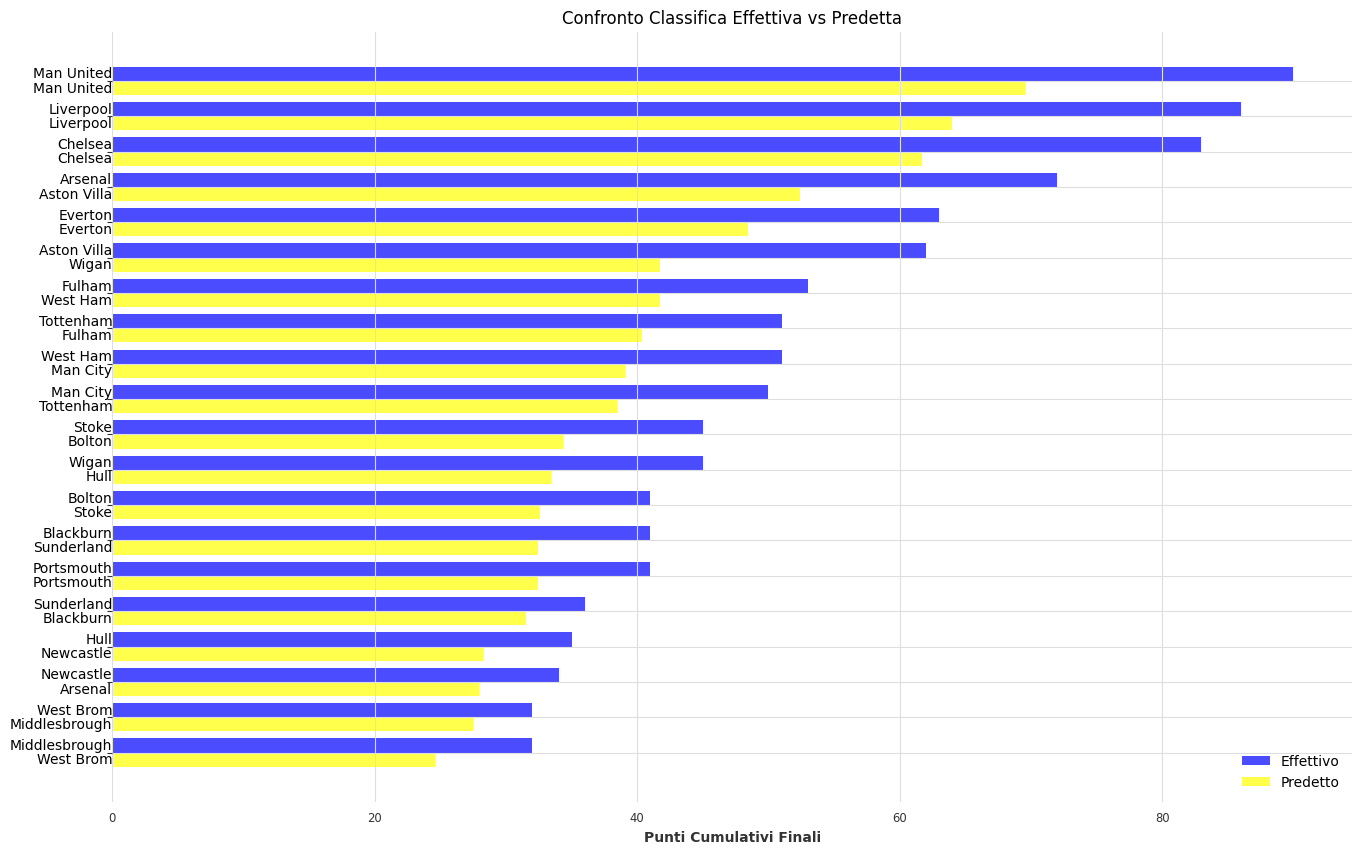

In [63]:
compare_positions(predictions)